In [38]:
### Making the dataset long format for analysis

import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("all_data_twotasks.csv")
df_long = pd.melt(
    df,
    id_vars=['subject', 'cnd'],
    value_vars=['d1', 'd5'],
    var_name='score_time',
    value_name='score'
)

subjects_per_group = df_long.groupby('cnd')['subject'].nunique()
print(subjects_per_group)

cnd
Control         10
Full            10
Reactivation    10
Name: subject, dtype: int64


In [40]:
### for later if we want to compare d2 and d5 scores in the full training group

df = pd.read_csv("all_data_twotasks.csv")
df_long_day2 = pd.melt(
    df,
    id_vars=['subject', 'cnd'],
    value_vars=['d2', 'd5'],
    var_name='score_time',
    value_name='score'
)

In [41]:
### Perform one-way ANOVA on day 1 scores to see if there are significant differences between conditions
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Filter data for day 1 scores only
df_d1 = df_long[df_long['score_time'] == 'd1']

model = ols('score ~ cnd', data=df_d1).fit()
anova_table = sm.stats.anova_lm(model, typ=2) 

print(anova_table)


                 sum_sq    df         F    PR(>F)
cnd         1563.674069   2.0  0.094335  0.910277
Residual  223773.090653  27.0       NaN       NaN


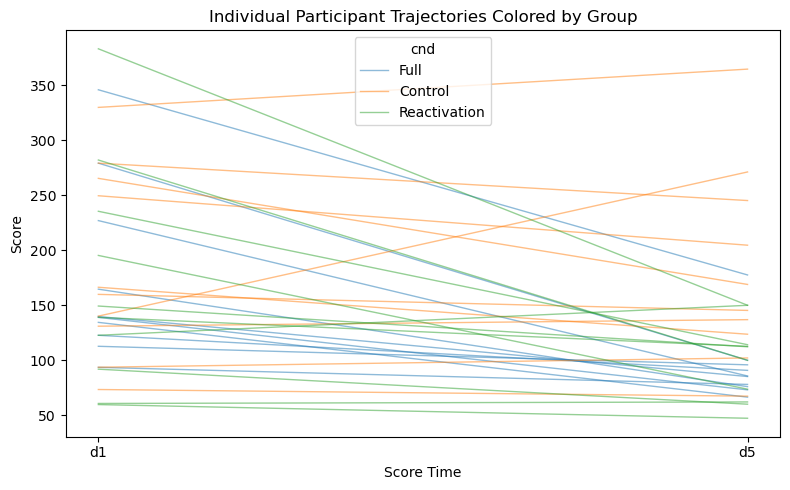

In [42]:
### checking individual participant trajectories colored by group
import seaborn as sns

plt.figure(figsize=(8, 5))

sns.lineplot(
    data=df_long,
    x="score_time",
    y="score",
    hue="cnd",         
    units="subject",    
    estimator=None,     
    alpha=0.5,
    lw=1
)

plt.title("Individual Participant Trajectories Colored by Group")
plt.xlabel("Score Time")
plt.ylabel("Score")
plt.tight_layout()
plt.show()


             Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    score   
No. Observations:    20         Method:                REML    
No. Groups:          10         Scale:                 815.3618
Min. group size:     2          Log-Likelihood:        -95.8240
Max. group size:     2          Converged:             Yes     
Mean group size:     2.0                                       
---------------------------------------------------------------
                  Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
---------------------------------------------------------------
Intercept         135.362   16.243  8.334 0.000 103.527 167.197
score_time[T.d5]  -42.501   12.770 -3.328 0.001 -67.530 -17.473
Group Var        1822.861   52.077                             



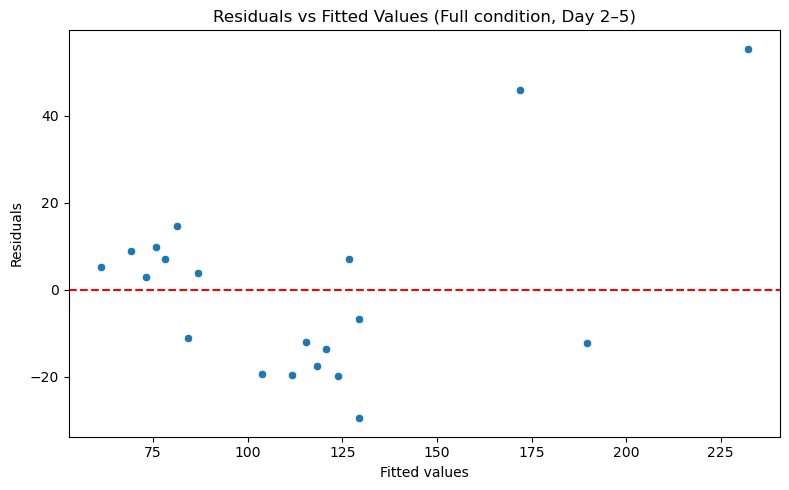

In [43]:
# Did day 2 to day 5 scores change in the Full group?
df_full = df_long_day2[(df_long_day2['cnd'] == 'Full') & (df_long_day2['score_time'].isin(['d2', 'd5']))]
df_full = df_full.copy()
subjects_per_group = df_long.groupby('cnd', observed=True)['subject'].nunique()


# Fit LMM: random intercept and slope for Time per subject
model = smf.mixedlm(
    "score ~ score_time",
    data=df_full,
    groups=df_full["subject"],
)
result = model.fit()
print(result.summary())

# Add fitted and residuals to dataframe
df_full['fitted'] = result.fittedvalues
df_full['residuals'] = result.resid

# Plot residuals vs fitted values
plt.figure(figsize=(8, 5))
sns.scatterplot(x='fitted', y='residuals', data=df_full)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (Full condition, Day 2–5)')
plt.tight_layout()
plt.show()



                        Mixed Linear Model Regression Results
Model:                      MixedLM           Dependent Variable:           score    
No. Observations:           60                Method:                       REML     
No. Groups:                 30                Scale:                        1574.7296
Min. group size:            2                 Log-Likelihood:               -308.1763
Max. group size:            2                 Converged:                    Yes      
Mean group size:            2.0                                                      
-------------------------------------------------------------------------------------
                                       Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
-------------------------------------------------------------------------------------
Intercept                              188.774   28.789  6.557 0.000  132.349 245.199
score_time[T.d5]                        -5.843   22.113 -0.264 0.792  -49.184 

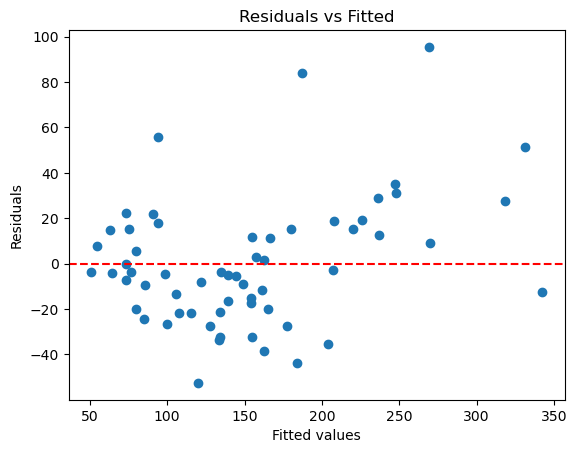

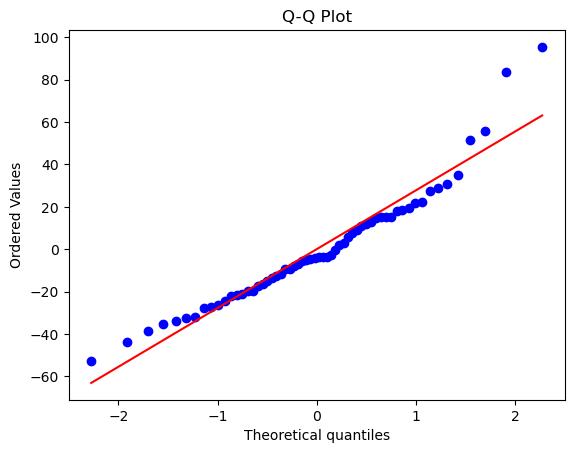

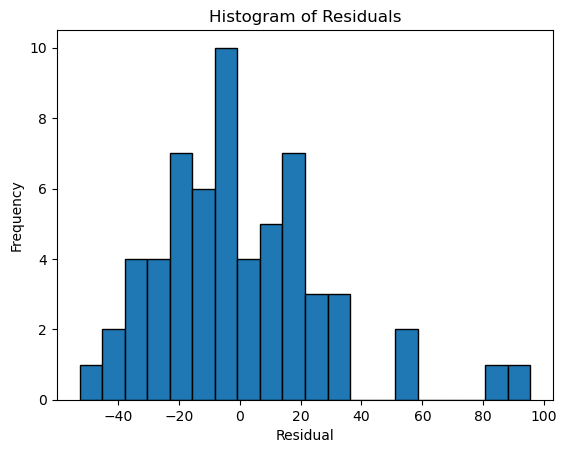

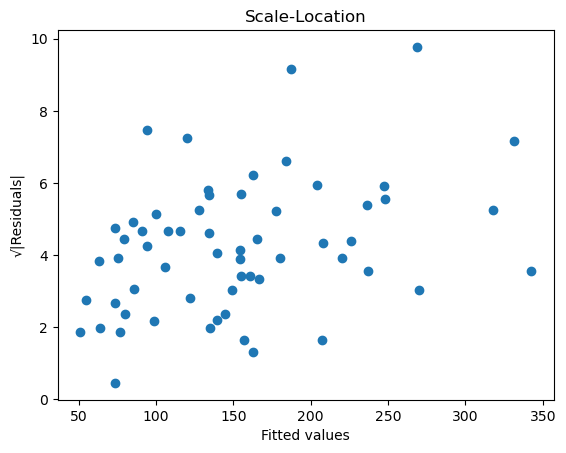

<F test: F=0.09433500782171116, p=0.9101274879417923, df_denom=54, df_num=2>


In [44]:
# Set Control as reference group (first in categories)
df_long['cnd'] = pd.Categorical(df_long['cnd'], categories=['Control', 'Full','Reactivation'])

# Fit linear mixed model: this gives you the exact formula you want
model = smf.mixedlm(
    "score ~ score_time * cnd",
    data=df_long,
    groups=df_long["subject"],
    re_formula="~score_time"
)
result = model.fit()
print(result.summary())

import matplotlib.pyplot as plt
import scipy.stats as stats

# Extract fitted values and residuals
fitted = result.fittedvalues
residuals = result.resid

# 1. Residuals vs Fitted (check homoscedasticity, linearity)
plt.scatter(fitted, residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

# 2. Q-Q plot (check normality of residuals)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

# 3. Histogram of residuals
plt.hist(residuals, bins=20, edgecolor="k")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

# 4. Scale-Location plot (sqrt|residuals| vs fitted)
plt.scatter(fitted, abs(residuals) ** 0.5)
plt.xlabel("Fitted values")
plt.ylabel("√|Residuals|")
plt.title("Scale-Location")
plt.show()
# Joint test for Full vs Control AND Reactivation vs Control
joint_test = result.f_test("cnd[T.Full] = cnd[T.Reactivation] = 0")
print(joint_test)



                        Mixed Linear Model Regression Results
Model:                      MixedLM           Dependent Variable:           score    
No. Observations:           60                Method:                       REML     
No. Groups:                 30                Scale:                        1574.7296
Min. group size:            2                 Log-Likelihood:               -308.1763
Max. group size:            2                 Converged:                    Yes      
Mean group size:            2.0                                                      
-------------------------------------------------------------------------------------
                                       Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
-------------------------------------------------------------------------------------
Intercept                              175.823   28.789  6.107 0.000  119.399 232.248
score_time[T.d5]                       -82.963   22.113 -3.752 0.000 -126.304 

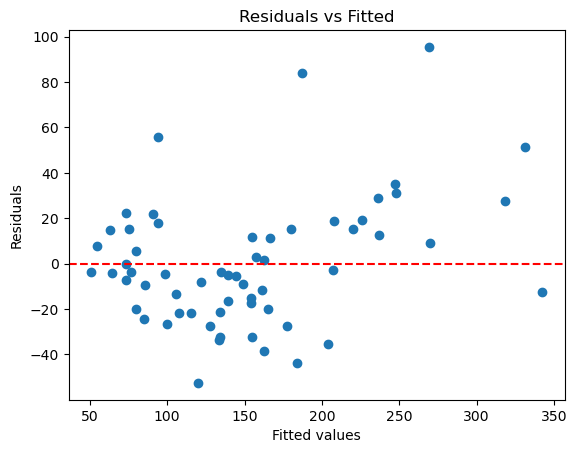

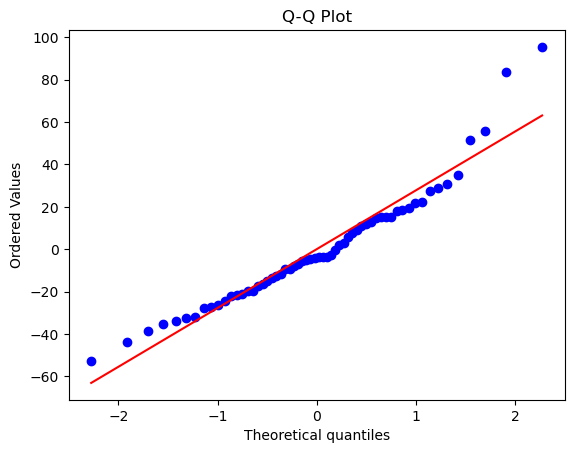

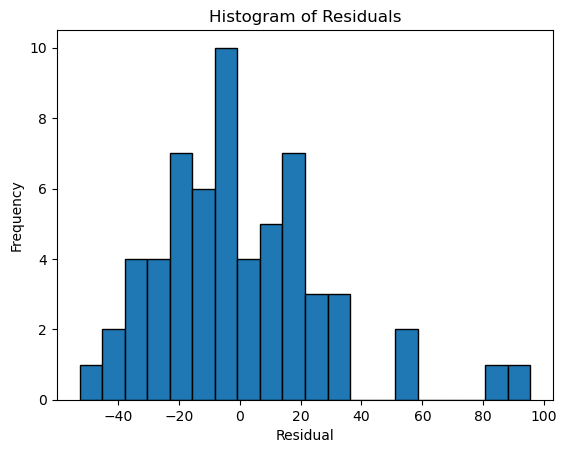

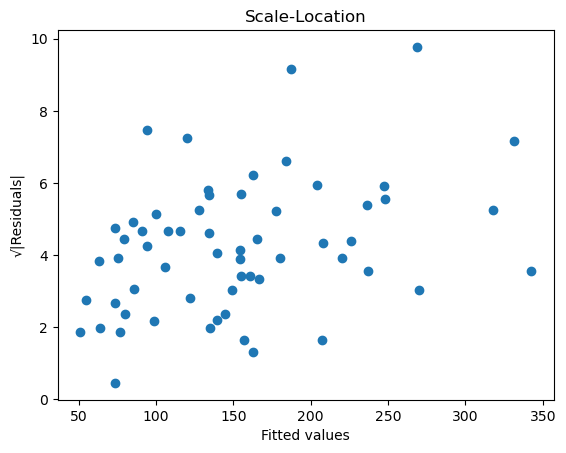

<F test: F=0.09433500782169951, p=0.9101274879418061, df_denom=54, df_num=2>


In [26]:
# Set Control as reference group (first in categories)
df_long['cnd'] = pd.Categorical(df_long['cnd'], categories=[ 'Full','Control','Reactivation'])

# Fit linear mixed model: this gives you the exact formula you want
model = smf.mixedlm(
    "score ~ score_time * cnd",
    data=df_long,
    groups=df_long["subject"],
    re_formula="~score_time"
)
result = model.fit()
print(result.summary())

import matplotlib.pyplot as plt
import scipy.stats as stats

# Extract fitted values and residuals
fitted = result.fittedvalues
residuals = result.resid

# 1. Residuals vs Fitted (check homoscedasticity, linearity)
plt.scatter(fitted, residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

# 2. Q-Q plot (check normality of residuals)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

# 3. Histogram of residuals
plt.hist(residuals, bins=20, edgecolor="k")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

# 4. Scale-Location plot (sqrt|residuals| vs fitted)
plt.scatter(fitted, abs(residuals) ** 0.5)
plt.xlabel("Fitted values")
plt.ylabel("√|Residuals|")
plt.title("Scale-Location")
plt.show()
# Joint test for Full vs Control AND Reactivation vs Control
joint_test = result.f_test("cnd[T.Control] = cnd[T.Reactivation] = 0")
print(joint_test)



                     Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         score    
No. Observations:          60              Method:                     REML     
No. Groups:                30              Scale:                      1574.7296
Min. group size:           2               Log-Likelihood:             -308.1763
Max. group size:           2               Converged:                  Yes      
Mean group size:           2.0                                                  
--------------------------------------------------------------------------------
                                  Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
--------------------------------------------------------------------------------
Intercept                         171.870   28.789  5.970 0.000  115.445 228.295
score_time[T.d5]                  -73.670   22.113 -3.331 0.001 -117.012 -30.329
cnd[T.Full]                         3.954   40.713

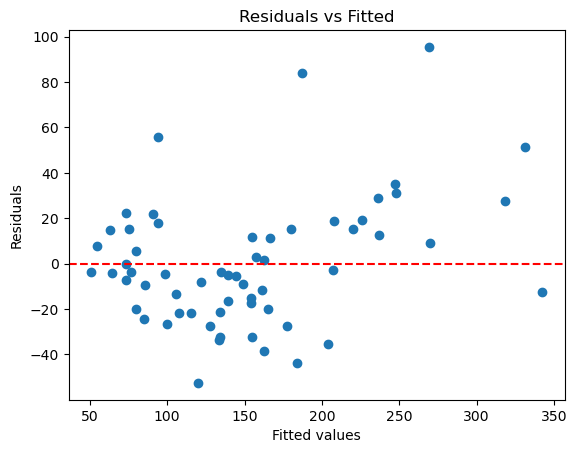

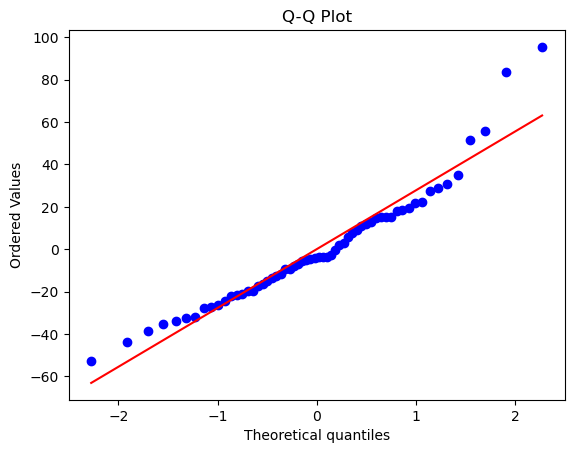

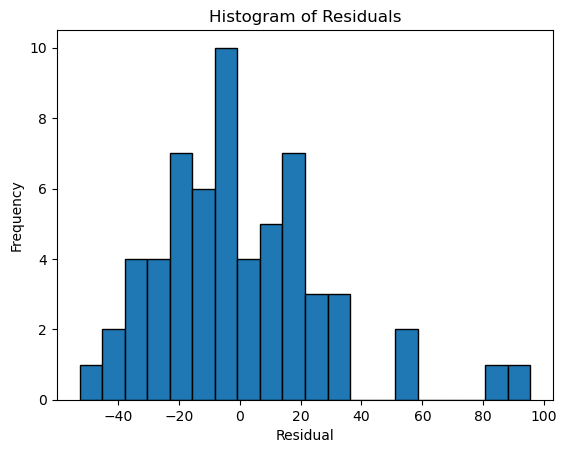

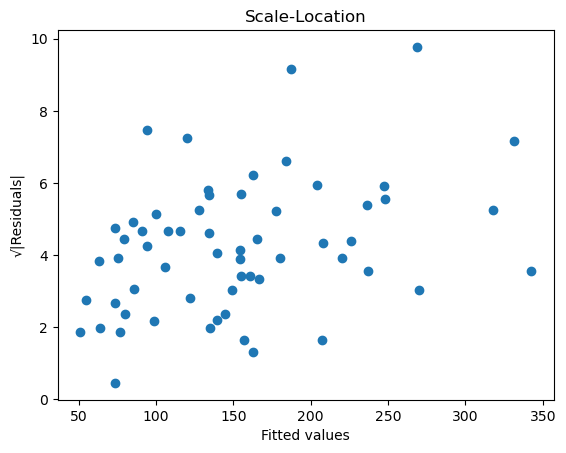

PatsyError: unrecognized token in constraint
    cnd[T.Full] = cnd[T.Reactivation] = 0
                  ^

In [27]:
# Set Control as reference group (first in categories)
df_long['cnd'] = pd.Categorical(df_long['cnd'], categories=[ 'Reactivation','Full','Control'])

# Fit linear mixed model: this gives you the exact formula you want
model = smf.mixedlm(
    "score ~ score_time * cnd",
    data=df_long,
    groups=df_long["subject"],
    re_formula="~score_time"
)
result = model.fit()
print(result.summary())

import matplotlib.pyplot as plt
import scipy.stats as stats

# Extract fitted values and residuals
fitted = result.fittedvalues
residuals = result.resid

# 1. Residuals vs Fitted (check homoscedasticity, linearity)
plt.scatter(fitted, residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

# 2. Q-Q plot (check normality of residuals)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

# 3. Histogram of residuals
plt.hist(residuals, bins=20, edgecolor="k")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

# 4. Scale-Location plot (sqrt|residuals| vs fitted)
plt.scatter(fitted, abs(residuals) ** 0.5)
plt.xlabel("Fitted values")
plt.ylabel("√|Residuals|")
plt.title("Scale-Location")
plt.show()
# Joint test for Full vs Control AND Reactivation vs Control
joint_test = result.f_test("cnd[T.Full] = cnd[T.Reactivation] = 0")
print(joint_test)



In [24]:
### Correlation between d5 scores and the percentage correction on 15 reminder trials in Reactivation group
from scipy.stats import pearsonr

df = pd.read_csv("all_data_twotasks.csv")
df_reactivation = df[df['cnd'] == 'Reactivation'].dropna(subset=['d5', 'reac_corr'])
corr_coef, p_value = pearsonr(df_reactivation['d5'], df_reactivation['reac_corr'])

print(f"Correlation between d5 scores and reac_corr in Reactivation group:")
print(f"r = {corr_coef:.3f}, p = {p_value:.3f}")


Correlation between d5 scores and reac_corr in Reactivation group:
r = 0.143, p = 0.714


Now looking at the transfer data

In [35]:
### Making the dataset now for transfer analysis

import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("all_data_twotasks.csv")

df_long_transfer = pd.melt(
    df,
    id_vars=['subject', 'cnd'],
    value_vars=['d5', 'Transfer'],
    var_name='score_time',
    value_name='score'
)

subjects_per_group = df_long.groupby('cnd', observed=True)['subject'].nunique()
print(subjects_per_group)

cnd
Control         10
Full            10
Reactivation    10
Name: subject, dtype: int64


                        Mixed Linear Model Regression Results
Model:                      MixedLM           Dependent Variable:           score    
No. Observations:           54                Method:                       REML     
No. Groups:                 30                Scale:                        1090.7110
Min. group size:            1                 Log-Likelihood:               -269.8808
Max. group size:            2                 Converged:                    Yes      
Mean group size:            1.8                                                      
-------------------------------------------------------------------------------------
                                       Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
-------------------------------------------------------------------------------------
Intercept                              181.581   29.662  6.122 0.000  123.444 239.718
score_time[T.d5]                         1.350   21.941  0.062 0.951  -41.654 

/var/folders/b0/lql08qjj4gz4nxl4zqz30lsm0000gn/T/ipykernel_2171/978030060.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_long_transfer['cnd'] = pd.Categorical(df_long_transfer['cnd'], categories=['Control', 'Full','Reactivation'])


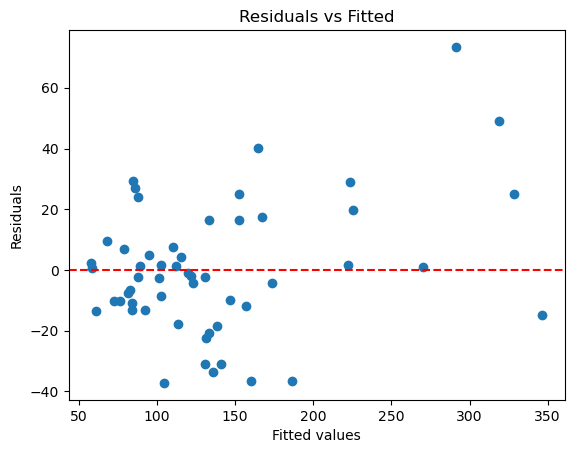

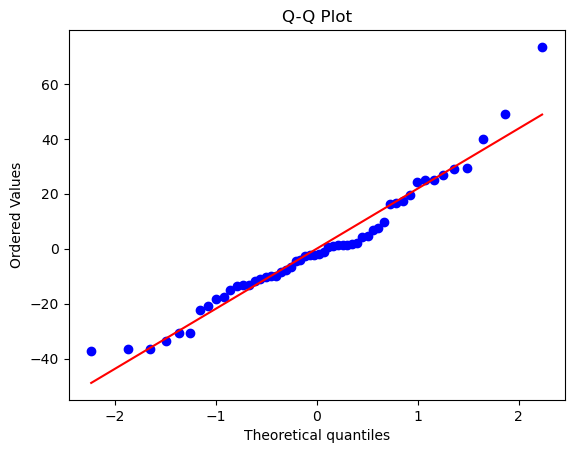

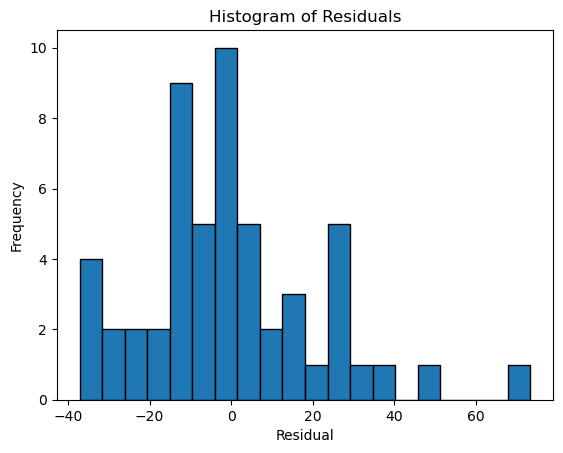

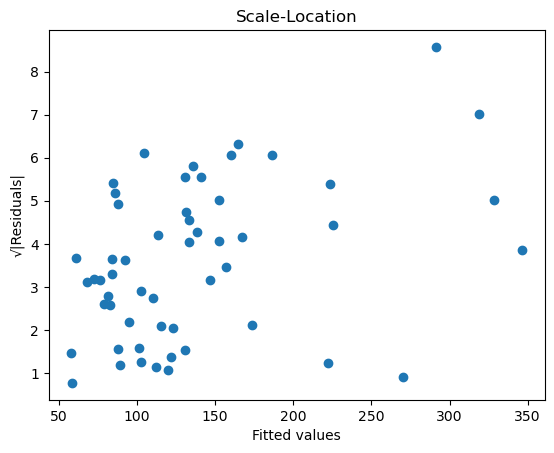

<F test: F=0.8975387045093852, p=0.41430083904682913, df_denom=48, df_num=2>


In [37]:
# Set Control as reference group (first in categories)
df_long_transfer = df_long_transfer.dropna(subset=['score','score_time','cnd'])

df_long_transfer['cnd'] = pd.Categorical(df_long_transfer['cnd'], categories=['Control', 'Full','Reactivation'])

# Fit linear mixed model: this gives you the exact formula you want
model = smf.mixedlm(
    "score ~ score_time * cnd",
    data=df_long_transfer,
    groups=df_long_transfer["subject"],
    re_formula="~score_time"
)
result = model.fit()
print(result.summary())

import matplotlib.pyplot as plt
import scipy.stats as stats

# Extract fitted values and residuals
fitted = result.fittedvalues
residuals = result.resid

# 1. Residuals vs Fitted (check homoscedasticity, linearity)
plt.scatter(fitted, residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

# 2. Q-Q plot (check normality of residuals)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

# 3. Histogram of residuals
plt.hist(residuals, bins=20, edgecolor="k")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

# 4. Scale-Location plot (sqrt|residuals| vs fitted)
plt.scatter(fitted, abs(residuals) ** 0.5)
plt.xlabel("Fitted values")
plt.ylabel("√|Residuals|")
plt.title("Scale-Location")
plt.show()
# Joint test for Full vs Control AND Reactivation vs Control
joint_test = result.f_test("cnd[T.Full] = cnd[T.Reactivation] = 0")
print(joint_test)

